<a href="https://colab.research.google.com/github/jakecupani/marsrover/blob/main/Mars_Surface_Image_Classification_Jake_Cupani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jake Cupani
# INST767
# 5/18/22

<hr>

# Background

Mars is an extremely interesting planet because it is thought to have been at one time similar in conditions to Earth.	 If the red planet previously had similar conditions, one might think that there is the potential for the existence, or past existence, of microbial life. The Mars Curiosity is one of the more recent Mars rovers developed by NASA, launched in November of 2011. Curiosity was launched with the aim of identifying if Mars ever had the right conditions for past microbial life [3]. With the many scientific instruments on the Mars Curiosity rover, the rover has taken a total of over 930,000 pictures [4]. These images could not only be used to make new scientific discoveries on Mars, but also to train new machine learning models to improve the technical capabilities of future martian rovers.

# Dataset

The dataset that I am using in this project is the “Mars surface image (Curiosity rover) labeled data set” available [here](https://zenodo.org/record/1049137). This dataset was published in November of 2017 and contains 6,691 images across 24 classes. The images were collected by the Mars Science Laboratory, which conducts the Curiosity rover mission. The images were taken through the rover’s on board instruments, the Mastcam Right eye, Mastcam Left eye, and MAHLI [2]. These instruments allow for detailed imagery of the martian surface. More specifically, the Mastcam takes color images and video to study geographic features and terrain navigation, whereas the MAHLI is a camera that is able to take close up images of minerals and surface rocks [5]. The images in this dataset have been preprocessed into “thumbnail” versions (256 x 256) from the raw images. This will allow for easier data importing and processing when developing the model. The dataset also contains text files for which images to use for training, validation, and testing. However, since I will be developing a binary classification model, we will be grouping some classes together. The classes 5, 8, and 9 represent the “drill holes”, “ground”, and “horizon” classes, respectively. These classes were changed to the label “Surface”, and all other rover classes were labeled “Rover”. Since the images were all in one folder they needed to be in separate folders for training, validation, and test, with each folder containing “Rover” and “Surface” subdirectories. This follows the convention used in tensorflow projects. In order to create these directories correctly, I created a function in my code called createDirectories(), which copies each of the images from the base folder by file path and pastes them into newly created folders and subdirectories.

# Research Problem

In this project, I will be developing a binary image classification model from the Mars Curiosity labeled image dataset. This project focuses mainly on creating a binary classification model for determining if a given image contains a rover, or is a martian surface. By framing this research problem as a binary classification, the model doesn’t have to be overly complex since it only has to determine two classes instead of the given 24.

# Tried Previously

Previously, I tried developing an image classification model using the dataset with all 24 classes. This posed significant challenges to creating a robust model because the model was only being trained on a very limited set of images. By framing this model as a binary classification model, the model doesn’t have to be overly complex since it only has to determine two classes instead of the given 24. This also increases the number of images that the model is able to train on significantly. Additionally, I initially tried creating a model with multiple layers and many neurons per layer, however my results were not great. The model was overfitting because the validation loss was increasing way above the training loss. In order to address this problem, I increased the dropout rate to 0.5, removed a layer, and reduced the number of neurons per layer. This ultimately helps reduce overfitting and reduces validation loss.



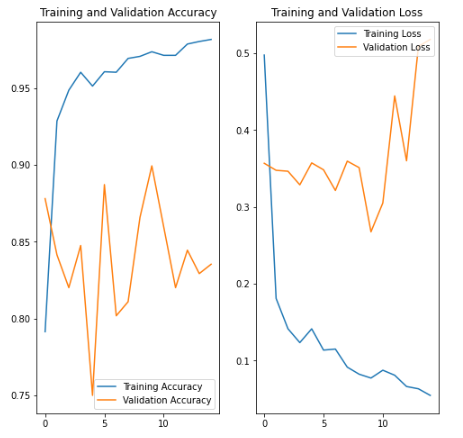

# Current Work Code

## Imports & Dependencies

In [20]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load Data

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
rootfp = "/content/drive/MyDrive/Mars Surface/"

ref_df = pd.read_csv(rootfp + "msl_synset_words-indexed.txt",header=None,delimiter='\d+',usecols=[1])
ref_df = ref_df.reset_index()
ref_df.columns = ['class','label']
ref_df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,class,label
0,0,apxs
1,1,apxs cal target
2,2,chemcam cal target
3,3,chemin inlet open
4,4,drill
5,5,drill holes
6,6,drt front
7,7,drt side
8,8,ground
9,9,horizon


In [23]:
test_inds = pd.read_csv(rootfp + "test-calibrated-shuffled.txt",header=None,delimiter=' ')
test_inds.columns = ['filepath','class']

test_inds['use'] = ['test'] * len(test_inds)

test_inds

,filepath,class,use
0,calibrated/0830MR0036510000500684E01_DRCL.JPG,7,test
1,calibrated/0640MH0002640000203781I01_DRCL.JPG,24,test
2,calibrated/0647MH0003250050203806E01_DRCL.JPG,9,test
3,calibrated/0844MR0037590000501001I01_DRCL.JPG,7,test
4,calibrated/0618MR0026460020401253I01_DRCL.JPG,11,test
...,...,...,...
1300,calibrated/0571MH0002590000201894I01_DRCL.JPG,24,test
1301,calibrated/0840ML0037090000401385I01_DRCL.JPG,17,test
1302,calibrated/0868MH0003900000302200I01_DRCL.JPG,10,test
1303,calibrated/0568MH0002630000201882E01_DRCL.JPG,24,test


In [24]:
train_inds = pd.read_csv(rootfp + "train-calibrated-shuffled.txt",header=None,delimiter=' ')
train_inds.columns = ['filepath','class']

train_inds['use'] = ['train'] * len(train_inds)

train_inds

,filepath,class,use
0,calibrated/0077ML0005780000102730I01_DRCL.JPG,15,train
1,calibrated/0072MR0005610170103642E01_DRCL.JPG,8,train
2,calibrated/0069MR0004130000103477I01_DRCL.JPG,21,train
3,calibrated/0154ML0008510010104492E01_DRCL.JPG,8,train
4,calibrated/0019MR0000530000100138C00_DRCL.JPG,8,train
...,...,...,...
3741,calibrated/0163ML0008760050104602D01_DRCL.JPG,10,train
3742,calibrated/0072MR0005620000103655E01_DRCL.JPG,8,train
3743,calibrated/0066ML0003650000102517M00_DRCL.JPG,21,train
3744,calibrated/0157ML0008550020104531I01_DRCL.JPG,8,train


In [25]:
val_inds = pd.read_csv(rootfp + "val-calibrated-shuffled.txt",header=None,delimiter=' ')
val_inds.columns = ['filepath','class']

val_inds['use'] = ['validation'] * len(val_inds)

val_inds

,filepath,class,use
0,calibrated/0292MH0002810020103587C00_DRCL.JPG,5,validation
1,calibrated/0270MH0002530050102760I01_DRCL.JPG,5,validation
2,calibrated/0549MH0002620000201566E01_DRCL.JPG,24,validation
3,calibrated/0229MR0009720000202913E01_DRCL.JPG,0,validation
4,calibrated/0292MH0002810020103613C00_DRCL.JPG,5,validation
...,...,...,...
1635,calibrated/0486MR0011580000302944E01_DRCL.JPG,0,validation
1636,calibrated/0506MH0002240020200655I01_DRCL.JPG,8,validation
1637,calibrated/0229MR0010840000202939I01_DRCL.JPG,16,validation
1638,calibrated/0229MR0009760000202918I01_DRCL.JPG,18,validation


In [26]:
all_images_df = pd.concat([test_inds,val_inds,train_inds],ignore_index=True)

surface = [5,8,9]
all_images_df['class'] = ["Surface" if (c in surface) else "Rover" for c in all_images_df['class']]

all_images_df

,filepath,class,use
0,calibrated/0830MR0036510000500684E01_DRCL.JPG,Rover,test
1,calibrated/0640MH0002640000203781I01_DRCL.JPG,Rover,test
2,calibrated/0647MH0003250050203806E01_DRCL.JPG,Surface,test
3,calibrated/0844MR0037590000501001I01_DRCL.JPG,Rover,test
4,calibrated/0618MR0026460020401253I01_DRCL.JPG,Rover,test
...,...,...,...
6686,calibrated/0163ML0008760050104602D01_DRCL.JPG,Rover,train
6687,calibrated/0072MR0005620000103655E01_DRCL.JPG,Surface,train
6688,calibrated/0066ML0003650000102517M00_DRCL.JPG,Rover,train
6689,calibrated/0157ML0008550020104531I01_DRCL.JPG,Surface,train


In [27]:
print("Number of Images: ",len(all_images_df))
print("Number of Images in Train Set", len(all_images_df[all_images_df['use'] == 'train']))
print("Number of Images in Validation Set", len(all_images_df[all_images_df['use'] == 'validation']))
print("Number of Images in Test Set", len(all_images_df[all_images_df['use'] == 'test']))

Number of Images:  6691
Number of Images in Train Set 3746
Number of Images in Validation Set 1640
Number of Images in Test Set 1305


## Directory Setup

In [28]:
def createDirectory():
  data_path = "/content/drive/MyDrive/Mars Surface/dataset/"
  folders = ['train','test','validation']
  classes = ['Surface','Rover']

  # make new directories if doesn't exist
  for f in folders:
    for i in classes:
      newpath = data_path + f + "/" + str(i)
      if not os.path.exists(newpath):
          os.makedirs(newpath)

  # defining test source and destination
  src = '/content/drive/MyDrive/Mars Surface/'
  trg = '/content/drive/MyDrive/Mars Surface/dataset/'
    
  for x in range(len(all_images_df)):
    class_label = all_images_df['class'][x]
    folder_name = all_images_df['use'][x]

    from_fp = all_images_df['filepath'][x]
    to_fp = trg + folder_name + "/" + class_label

    print(from_fp)
    print(to_fp)
    print('----------------------') 
    
    shutil.copy2(os.path.join(src,from_fp), to_fp)

In [29]:
# createDirectory()

## TensorFlow Model

In [30]:
batch_size = 32
img_height = 256
img_width = 256

data_dir = "/content/drive/MyDrive/Mars Surface/dataset/train"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3746 files belonging to 2 classes.


In [31]:
data_dir = "/content/drive/MyDrive/Mars Surface/dataset/validation"

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1640 files belonging to 2 classes.


In [32]:
class_names = train_ds.class_names
print(class_names)

['Rover', 'Surface']


In [33]:
import matplotlib.pyplot as plt

# Visualizing Augmentation
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
normalization_layer = layers.Rescaling(1./255)

In [36]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]

# print(np.min(first_image), np.max(first_image))

In [37]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    # layers.RandomRotation(0.1),
    # layers.RandomZoom(0.1),
    
  ]
)

In [38]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

In [39]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'), # Reduce size
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Removed layers to simplify model, reduce validation loss
  # layers.Conv2D(32, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  
  layers.Dropout(0.5), # Increase to 0.5
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [42]:
epochs = 15

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
118/118 [==============================] - 197s 2s/step - loss: 0.5220 - accuracy: 0.8513 - val_loss: 0.2513 - val_accuracy: 0.9183
Epoch 2/15
118/118 [==============================] - 3s 27ms/step - loss: 0.1253 - accuracy: 0.9568 - val_loss: 0.2860 - val_accuracy: 0.9006
Epoch 3/15
118/118 [==============================] - 3s 27ms/step - loss: 0.0781 - accuracy: 0.9738 - val_loss: 0.1857 - val_accuracy: 0.9073
Epoch 4/15
118/118 [==============================] - 3s 27ms/step - loss: 0.0449 - accuracy: 0.9864 - val_loss: 0.2378 - val_accuracy: 0.9043
Epoch 5/15
118/118 [==============================] - 3s 27ms/step - loss: 0.0473 - accuracy: 0.9861 - val_loss: 0.2500 - val_accuracy: 0.8963
Epoch 6/15
118/118 [==============================] - 3s 27ms/step - loss: 0.0327 - accuracy: 0.9872 - val_loss: 0.1925 - val_accuracy: 0.9183
Epoch 7/15
118/118 [==============================] - 3s 27ms/step - loss: 0.0213 - accuracy: 0.9928 - val_loss: 0.1710 - val_accuracy: 0.9305

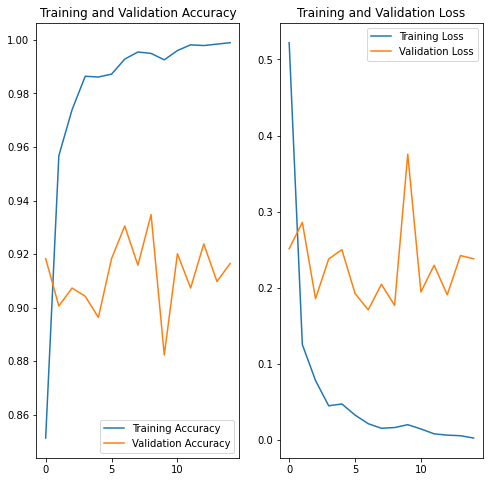

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing Phase

In [44]:
# batch_size = 32
# img_height = 256
# img_width = 256

# data_dir = "/content/drive/MyDrive/Mars Surface/dataset/test"

# test_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [45]:
# epochs = 15

# history = model.fit(
#   train_ds,
#   validation_data=test_ds,
#   epochs=epochs
# )

In [46]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
# model.save("mars_surface.model")

# Main Findings

In this project, my main findings were that it is possible to create a binary image classification model with the labeled Mars Curiosity rover dataset. The model performed relatively well. The figure below shows the performance of the model based on its training accuracy over time and training loss over time. It also performed relatively well on the test set with an accuracy of around __. Overall these are significant findings, given that this is only a small dataset compared to the total number of images available to the Curiosity rover team.


*image*

# Future Work, Limitations, and Lessons Learned

As with any work, there are always limitations and ways in which the project could be improved. For example, in future iterations of this project, more images could be collected from other NASA resources, or even the newly launched Perseverance rover. Additionally, this project was limited by the performance of the model. Further improvements could be made to tweaking parameters to optimize the model and lower the validation loss, and prevent any overfitting. Furthermore, this project could be used in the future to help scientists filter out images that contain the rover, if they only wish to see surface images. During the course of this project, I learned a lot about how to develop image classification models using TensorFlow. I haven't had any previous experience with TensorFlow, so this was a great learning experience. I also learned about overfitting models and that measures can be taken, such as increasing dropout or decreasing number of layers or neurons, to prevent overfitting and decrease validation loss.

# Conclusion

# References

1.   Wagstaff, K., Lu, Y., Stanboli, A., Grimes, K., Gowda, T., & Padams, J. (2018, April). Deep Mars: CNN classification of mars imagery for the PDS imaging atlas. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 32, No. 1).
2.   Alice Stanboli, & Kiri Wagstaff. (2017). Mars surface image (Curiosity rover) labeled data set (1.0.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1049137
3. NASA. (2021, July 7). Mars Curiosity Overview. NASA. Retrieved May 17, 2022, from https://mars.nasa.gov/msl/mission/overview/ 
4. NASA. (2021, July 7). Mars Curiosity Home. NASA. Retrieved May 17, 2022, from https://mars.nasa.gov/msl/mission/home/ 
5. NASA. (2021, July 7). Mars Curiosity Science. NASA. Retrieved May 17, 2022, from https://mars.nasa.gov/msl/mission/science/summary/
6. Image classification  :   Tensorflow Core. TensorFlow. (2022, January 26). Retrieved May 17, 2022, from https://www.tensorflow.org/tutorials/images/classification#data_augmentation 

